In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort
from albumentations.pytorch import ToTensorV2
import albumentations as A
import warnings
warnings.filterwarnings("ignore")

In [2]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/answer.csv", header=None)
df.columns = ['file','target']
print("Target ### Total:  {}".format(len(df)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
Target ### Total:  1242


In [3]:
df_train = pd.DataFrame()
df_train['image_path'] = images_train
df_train['target'] = df['target']
df_train['dataset']  = 'solafune'

In [4]:
df_train.head()

,image_path,target,dataset
0,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
1,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
2,/home/sebastien/Documents/projects/solafune-fi...,0,solafune
3,/home/sebastien/Documents/projects/solafune-fi...,1,solafune
4,/home/sebastien/Documents/projects/solafune-fi...,0,solafune


In [5]:
def data_augmentation(image, verbose=False):

    optical_transform = A.Compose([
    A.HorizontalFlip(p=random.uniform(0, 1)),
    A.VerticalFlip(p=random.uniform(0, 1)),
    A.RandomBrightnessContrast(p=random.uniform(0, 1)),
    A.RandomGamma(p=random.uniform(0, 1)),
    # A.GaussNoise(p=random.uniform(0, 1)),
    A.ColorJitter(p=random.uniform(0, 1))])
    
    apply_transform = ["yes", "no"]
    if random.choice(apply_transform)=="yes":
        augmented = optical_transform(image=image)
        aug_image = augmented['image']

        transform_info = optical_transform.get_dict_with_id()
        
        print("Applied transformations:")
        for key, value in transform_info.items():
            print(f"{key}: {value}")
    else:
        aug_image = image
        
    if verbose:
        import matplotlib.pyplot as plt

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(image)
        ax1.set_title("Image")
        ax1.axis('off')
        ax2.imshow(aug_image)
        ax2.set_title("Augmented Image")
        ax2.axis('off')
    return aug_image

In [6]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))
def image_preprocessing(image_path):

    image = xr.open_rasterio(image_path, masked=False).values
    
def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    
    
    return rgb_composite_n

In [7]:
img_path = df_train.image_path.iloc[60]

image = image_preprocessing(img_path)
image.shape

(512, 512, 3)

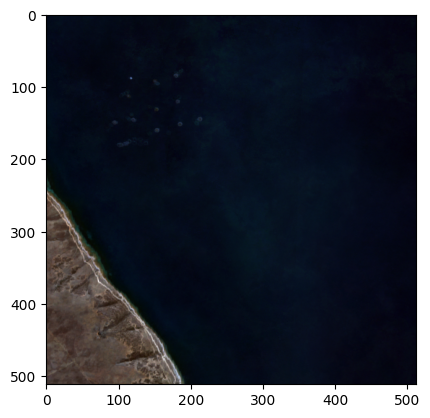

In [8]:
plt.imshow(image)

Applied transformations:
__class_fullname__: Compose
id: 140607378956096
params: None
transforms: [{'__class_fullname__': 'HorizontalFlip', 'always_apply': False, 'p': 0.7115911618155052, 'id': 140607378955952}, {'__class_fullname__': 'VerticalFlip', 'always_apply': False, 'p': 0.7652124551880092, 'id': 140607378956000}, {'__class_fullname__': 'RandomBrightnessContrast', 'always_apply': False, 'p': 0.7062364424912502, 'brightness_limit': (-0.2, 0.2), 'contrast_limit': (-0.2, 0.2), 'brightness_by_max': True, 'id': 140607378954272}, {'__class_fullname__': 'RandomGamma', 'always_apply': False, 'p': 0.5263478346150161, 'gamma_limit': (80, 120), 'eps': None, 'id': 140607378954080}, {'__class_fullname__': 'ColorJitter', 'always_apply': False, 'p': 0.9912232921370052, 'brightness': [0.8, 1.2], 'contrast': [0.8, 1.2], 'saturation': [0.8, 1.2], 'hue': [-0.2, 0.2], 'id': 140607378955760}]
bbox_params: None
keypoint_params: None
additional_targets: {}
is_check_shapes: True


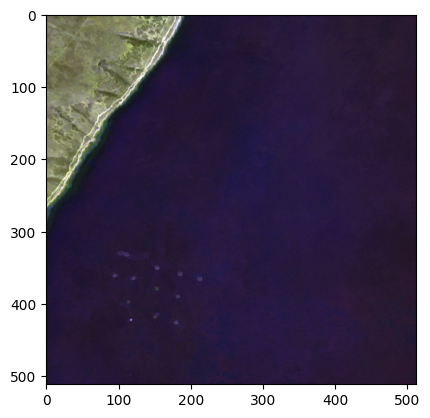

In [9]:
aug = data_augmentation(image)
plt.imshow(aug)

## NDVI , NDWI , NDBI 


In [10]:
def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    NDWI = (image[2,:,:]-image[7,:,:])/(image[2,:,:]+image[7,:,:])
    NDWI = normalize(NDWI)

    NDVI = (image[7,:,:]-image[3,:,:])/(image[7,:,:]+image[3,:,:])
    NDVI = normalize(NDVI)

    MSI = image[10,:,:]/image[7,:,:]
    MSI = normalize(MSI)

    NDBI = (image[10,:,:]-image[7,:,:])/(image[10,:,:]+image[7,:,:])
    
    
    return NDWI, NDVI, MSI, NDBI

In [11]:
nwdi, ndvi, msi, ndbi  = image_preprocessing(img_path)

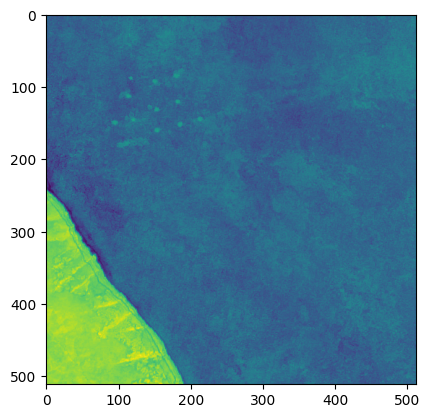

In [12]:
plt.imshow(ndvi)